In [97]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#设置中文
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False


In [98]:
"""
导入数据
"""
pd.set_option('mode.chained_assignment', None)
data = pd.read_excel('第一问预处理后的数据2.xlsx')
# 选取整晚睡眠时间（时：分：秒）,睡醒次数,入睡方式 这三列
data_3_lie = data [['整晚睡眠时间（时：分：秒）','睡醒次数','入睡方式']]
data_3_lie

,整晚睡眠时间（时：分：秒）,睡醒次数,入睡方式
0,10.0,3,2
1,11.0,0,4
2,12.0,1,2
3,11.0,2,1
4,10.5,1,4
...,...,...,...
375,9.0,1,2
376,11.0,2,4
377,10.5,2,1
378,6.0,2,1


In [99]:
"""
第一列是正向标准化,第二列是负向标准化,第三列是正向标准化
"""
data_3_lie['整晚睡眠时间（时：分：秒）'] = (data_3_lie['整晚睡眠时间（时：分：秒）']-data_3_lie['整晚睡眠时间（时：分：秒）'].min())/(data_3_lie['整晚睡眠时间（时：分：秒）'].max()-data_3_lie['整晚睡眠时间（时：分：秒）'].min())
data_3_lie['睡醒次数'] = (data_3_lie['睡醒次数'].max() - data_3_lie['睡醒次数'])/(data_3_lie['睡醒次数'].max()-data_3_lie['睡醒次数'].min())
data_3_lie['入睡方式'] = (data_3_lie['入睡方式']-data_3_lie['入睡方式'].min())/(data_3_lie['入睡方式'].max()-data_3_lie['入睡方式'].min())
data_3_lie

,整晚睡眠时间（时：分：秒）,睡醒次数,入睡方式
0,0.714286,0.7,0.25
1,0.857143,1.0,0.75
2,1.000000,0.9,0.25
3,0.857143,0.8,0.00
4,0.785714,0.9,0.75
...,...,...,...
375,0.571429,0.9,0.25
376,0.857143,0.8,0.75
377,0.785714,0.8,0.00
378,0.142857,0.8,0.00


In [100]:
"""
熵权法求熵权
"""
from scipy.stats import entropy
data_3_lie_380 = data_3_lie.iloc[0:380,:]
# 计算这三列的熵权值
# 计算每个指标的信息熵
entropy_list = []
for i in range(3):
    p = data_3_lie_380.iloc[:,i].value_counts()/len(data_3_lie_380.iloc[:,i])
    entropy_list.append(entropy(p))
# 计算每个指标的权重
weight_list = []
for j in range(3):
    weight_list.append((1-entropy_list[j])/(3-sum(entropy_list)))
weight_list



[0.4970682442522301, 0.30376948501336964, 0.19916227073440038]

In [101]:
# 计算data_3_lie_380的加权之后的得分
data_3_lie_380['score'] = data_3_lie_380['整晚睡眠时间（时：分：秒）']*weight_list[0]+data_3_lie_380['睡醒次数']*weight_list[1]+data_3_lie_380['入睡方式']*weight_list[2]
data_3_lie_380

,整晚睡眠时间（时：分：秒）,睡醒次数,入睡方式,score
0,0.714286,0.7,0.25,0.617478
1,0.857143,1.0,0.75,0.879200
2,1.000000,0.9,0.25,0.820251
3,0.857143,0.8,0.00,0.669074
4,0.785714,0.9,0.75,0.813318
...,...,...,...,...
375,0.571429,0.9,0.25,0.607222
376,0.857143,0.8,0.75,0.818446
377,0.785714,0.8,0.00,0.633569
378,0.142857,0.8,0.00,0.314025


C:\Users\44279\AppData\Local\Temp\ipykernel_1032\2838812038.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_3_lie_380['score'])


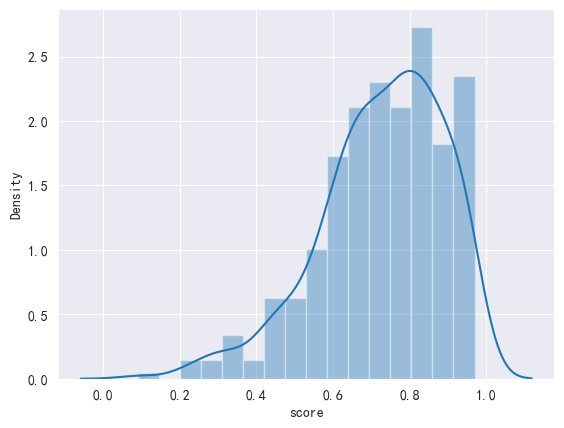

In [102]:
"""
画出score的分布图
"""
sns.distplot(data_3_lie_380['score'])
plt.show()


In [112]:
"""
将这380行数据按照score从大到小排序,分成四类,优,良,中,差 ,其中服从正态分布
"""
data_3_lie_380 = data_3_lie_380.sort_values(by='score',ascending=False)
# 得分小于0.6的记为差
data_3_lie_380.loc[data_3_lie_380['score']<0.5,'睡眠质量'] = '1'
# 得分大于0.6小于0.8的记为中
data_3_lie_380.loc[(data_3_lie_380['score']>=0.5)&(data_3_lie_380['score']<0.65),'睡眠质量'] = '2'
# 得分大于0.8小于0.9的记为良
data_3_lie_380.loc[(data_3_lie_380['score']>=0.65)&(data_3_lie_380['score']<0.81),'睡眠质量'] = '3'
# 得分大于0.9的记为优
data_3_lie_380.loc[data_3_lie_380['score']>=0.81,'睡眠质量'] = '4'

# 再将这380行数据按顺序排列
data_3_lie_380 = data_3_lie_380.sort_index()
# 将data3_lie_380输出为excel
data_3_lie_380.to_excel('第四问进行预测的数据2.xlsx')

In [111]:
data_3_lie_380

,整晚睡眠时间（时：分：秒）,睡醒次数,入睡方式,score,睡眠质量
0,0.714286,0.7,0.25,0.617478,2
1,0.857143,1.0,0.75,0.879200,4
2,1.000000,0.9,0.25,0.820251,3
3,0.857143,0.8,0.00,0.669074,2
4,0.785714,0.9,0.75,0.813318,3
...,...,...,...,...,...
375,0.571429,0.9,0.25,0.607222,2
376,0.857143,0.8,0.75,0.818446,3
377,0.785714,0.8,0.00,0.633569,2
378,0.142857,0.8,0.00,0.314025,1


In [105]:
from autogluon.tabular import TabularDataset, TabularPredictor
"""
进行预测检验正确率
"""
train_data = data_3_lie_380.iloc[0:300,:]
test_data = data_3_lie_380.iloc[300:380,:]
label = '睡眠质量'
predictor = TabularPredictor(label=label).fit(train_data)



	0.9833	 = Validation score   (accuracy)
	0.45s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	0.9833	 = Validation score   (accuracy)
	0.27s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	1.0	 = Validation score   (accuracy)
	1.1s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMLarge ...
	0.9833	 = Validation score   (accuracy)
	0.54s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	1.0	 = Validation score   (accuracy)
	0.41s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 8.23s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230813_020116\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230813_020125\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230813_020125\"

In [106]:
train_data

,整晚睡眠时间（时：分：秒）,睡醒次数,入睡方式,score,睡眠质量
0,0.714286,0.7,0.25,0.617478,2
1,0.857143,1.0,0.75,0.879200,4
2,1.000000,0.9,0.25,0.820251,3
3,0.857143,0.8,0.00,0.669074,2
4,0.785714,0.9,0.75,0.813318,3
...,...,...,...,...,...
295,0.428571,0.7,0.25,0.475458,1
296,0.714286,1.0,0.25,0.708609,3
297,1.000000,1.0,0.25,0.850628,4
298,0.785714,0.5,0.75,0.691810,2


In [107]:
y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred

300    2
301    3
302    3
303    3
304    3
      ..
375    2
376    3
377    2
378    1
379    3
Name: 睡眠质量, Length: 80, dtype: object

In [108]:
"""
模型检验
"""
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,0.9875,0.983333,0.001000,0.001000,0.580653,0.001000,0.001000,0.580653,1,True,13
1,LightGBM,0.9875,0.983333,0.002000,0.001000,0.532314,0.002000,0.001000,0.532314,1,True,5
2,NeuralNetTorch,0.9875,1.000000,0.007002,0.005004,1.096410,0.007002,0.005004,1.096410,1,True,12
3,KNeighborsDist,0.9875,0.933333,0.009001,0.012004,0.005001,0.009001,0.012004,0.005001,1,True,2
4,LightGBMXT,0.9875,1.000000,0.012003,0.002000,0.812316,0.012003,0.002000,0.812316,1,True,4
5,WeightedEnsemble_L2,0.9875,1.000000,0.014004,0.003000,1.225564,0.002001,0.001000,0.413249,2,True,14
6,XGBoost,0.9875,0.983333,0.019002,0.003003,0.299288,0.019002,0.003003,0.299288,1,True,11
7,RandomForestEntr,0.9875,0.983333,0.048011,0.033005,0.498244,0.048011,0.033005,0.498244,1,True,7
8,ExtraTreesGini,0.9875,0.983333,0.050012,0.041009,0.485257,0.050012,0.041009,0.485257,1,True,9
9,RandomForestGini,0.9875,0.983333,0.056013,0.035007,0.474107,0.056013,0.035007,0.474107,1,True,6
